# Facial Similarity 

Use image dataset from British Royal Family through the Deepface Model in order to determine if Prince William looks more like King Charles or Princess Diana

![Screenshot 2024-03-28 at 6.13.03 PM.png](<attachment:Screenshot 2024-03-28 at 6.13.03 PM.png>)

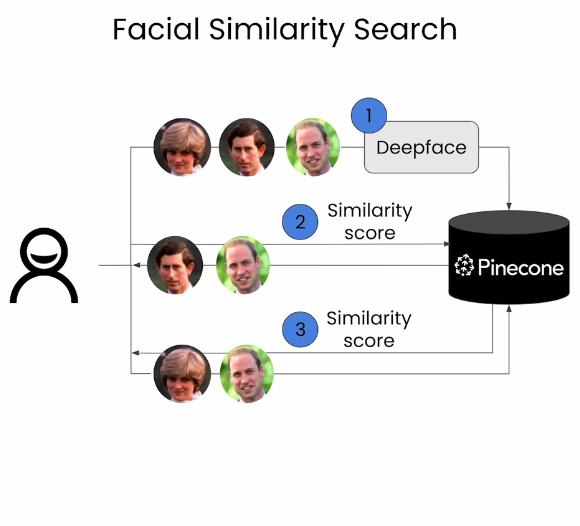

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from DLAIUtils import Utils


import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

24-03-28 18:37:04 - Directory /Users/dave/.deepface created
24-03-28 18:37:04 - Directory /Users/dave/.deepface/weights created


In [5]:
# ! unzip -q ../public/data/family_photos.zip

In [6]:
# get api key
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

## Load the Dataset 

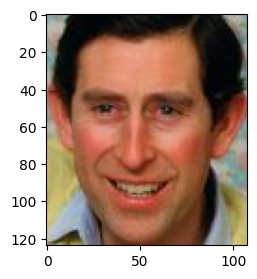

In [7]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('family/dad/P06260_face5.jpg')

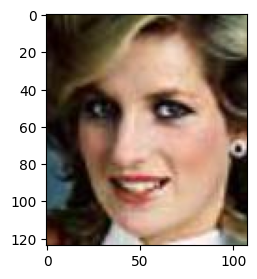

In [8]:
show_img('family/mom/P04407_face2.jpg')

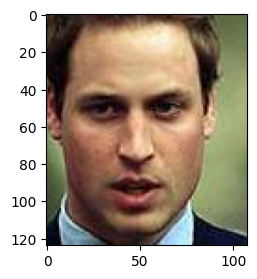

In [9]:
show_img('family/child/P04414_face1.jpg')

## Setup Pinecone 

In [10]:
MODEL = "Facenet"
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

## Create Embeddings Using DeepFace 

In [11]:
def generate_vectors():
	VECTOR_FILE = "./vectors.vec"

	# Suppress warnings and remove the vector file if it already exists
	with contextlib.suppress(FileNotFoundError):
		os.remove(VECTOR_FILE)
	
	# Open the vector file for writing to disk and glob all the images of the people separately and write the embeddings to the file
	with open(VECTOR_FILE, "w") as f:
		for person in ["mom", "dad", "child"]:
			files = glob.glob(f'family/{person}/*')
			for file in tqdm(files):
				try:
					embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
					f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
				except (ValueError, UnboundLocalError, AttributeError) as e:
					print(e)

generate_vectors()

  0%|          | 0/78 [00:00<?, ?it/s]

24-03-28 19:12:32 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /Users/dave/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 68.2MB/s]
100%|██████████| 93/93 [00:42<00:00,  2.18it/s]


In [12]:
!head -10 vectors.vec

mom:P11987_face1.jpg:[-1.8463152647018433, 0.27299022674560547, 0.04253186285495758, -0.8764521479606628, 0.6757092475891113, -0.1305600106716156, -0.3459167778491974, 1.7270901203155518, -0.6084268093109131, -0.2977624237537384, 1.3782219886779785, -1.043375015258789, -1.0426677465438843, -0.14226073026657104, 0.4242938160896301, -0.17434635758399963, 2.0169599056243896, 0.37401843070983887, 0.4458209276199341, -1.2389929294586182, -0.23586499691009521, -1.88418710231781, 0.2602965831756592, 0.302553653717041, -0.40339013934135437, 0.24789094924926758, 0.23313766717910767, 0.5171535611152649, -1.2493079900741577, 0.1795932650566101, 0.2168475091457367, -0.781201183795929, -0.04206669703125954, 1.0673184394836426, 0.7067726254463196, -0.475586861371994, 1.1671186685562134, 1.6654448509216309, -0.7330604791641235, -0.44103673100471497, -0.6169848442077637, -0.9232066869735718, 0.3781701624393463, 0.000468231737613678, -0.37705156207084656, -0.5465415716171265, 0.37758469581604004, -0.93

## Plot the Data of Images 

In [13]:
# Helper function iterates through the vector file and returns the embeddings for the specified person
# A key param of t-SNE is the perplexity, which is the number of nearest neighbors each data point has in the higher dimensional space
def gen_tsne_df(person, perplexity):
	vectors =[]
	with open('./vectors.vec', 'r') as f:
		for line in tqdm(f):
			p, orig_img, v = line.split(':')
			if person == p:
				vectors.append(eval(v))
	# PCA reduction for a specific person in the goal of reducing the number of dimensions
	pca = PCA(n_components=8)
	# TSNE reduction
	tsne = TSNE(2, perplexity=perplexity, random_state=0, n_iter=1000,
				verbose=0, metric='euclidean', learning_rate=75)
	print(f'transform {len(vectors)} vectors')
	pca_transform = pca.fit_transform(vectors)
	embeddings2d = tsne.fit_transform(pca_transform)
	return pd.DataFrame({'x': embeddings2d[:, 0], 'y': embeddings2d[:, 1]})


In [14]:
# Helper function to plot the data after PCA and TSNE reduction
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 5363.90it/s]


transform 70 vectors


241it [00:00, 5809.59it/s]


transform 93 vectors


241it [00:00, 7720.95it/s]


transform 78 vectors


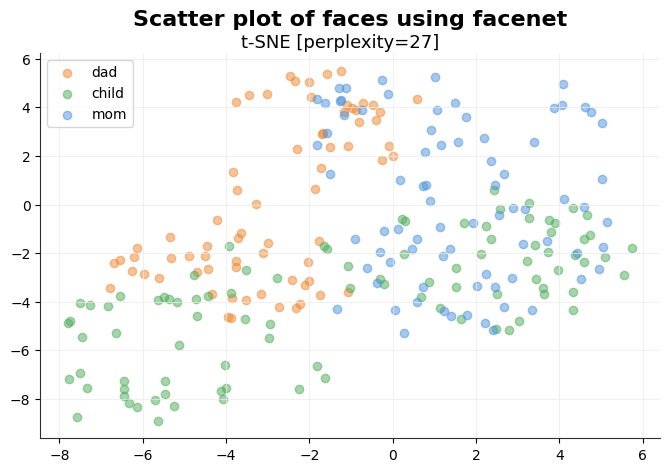

In [15]:
plot_tsne(27, 'facenet')

## Store embeddings in Pinecone 

In [16]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=128, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))

index = pinecone.Index(INDEX_NAME)

In [17]:
def store_vectors():
  with open("./vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [00:33,  7.15it/s]


In [18]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

## Calculate the Similarity Scores 

In [19]:
# Return top K similar images against the child
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  # 
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    # Calculate the average similarity score for the top K matches (returned value) from the query from Pinecone 
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [20]:
# Function to compute the similarity scores between the dad and child and mom and child
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 1589.94it/s]


DAD --------------------


100%|██████████| 10/10 [00:01<00:00,  9.48it/s]




dad AVG: 0.43616144289
MOM --------------------


100%|██████████| 10/10 [00:01<00:00,  9.13it/s]



mom AVG: 0.33877225011000006


## Check the Matching Images

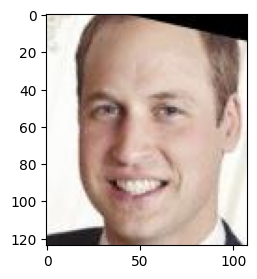

In [21]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [22]:
#Now find closest given we know dad is "most similar"
# Get the embedding of the child image
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5283985137939453, 1.286186933517456, -0.3561446964740753, -1.0126636028289795, 0.9982869029045105, 0.6666183471679688, 0.5679240822792053, 1.6064071655273438, 0.14698287844657898, -0.5307559370994568, 0.33921587467193604, -1.0853044986724854, -0.7407264709472656, -1.2022426128387451, -0.24404296278953552, -0.4366196393966675, -1.622046709060669, -2.924757480621338, -0.3545476794242859, -0.24917557835578918, 0.030633971095085144, -0.21422094106674194, -0.4420791566371918, -0.3180323839187622, -0.4128812551498413, -0.3246878385543823, 1.12881338596344, 0.46149662137031555, -0.8908525705337524, 0.5013217926025391, -1.8914412260055542, -0.10036294162273407, -2.00400710105896, -0.5636603832244873, 0.4059162735939026, -0.5800114274024963, -1.5189800262451172, -1.6227492094039917, 1.599508285522461, -0.30095773935317993, -0.9496636986732483, -1.9736130237579346, -2.5460360050201416, -0.24491259455680847, 1.7347702980041504, -1.6264370679855347, 1.3015146255493164, 0.9842944145202637, 0.856

In [23]:
#  Query the index for the top 3 results that match it from the dad
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [24]:
print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.438954532,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.419916511,
              'values': []},
             {'id': 'dad-P04408_face0.jpg',
              'metadata': {'file': 'P04408_face0.jpg', 'person': 'dad'},
              'score': 0.407586,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}


In [25]:
photo = query_response['matches'][0]['metadata']['file']

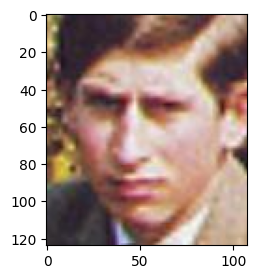

In [26]:
# Show the image that is most similar to the child image
show_img(f'family/dad/{photo}')